# Unsupervised Approach
In this notebook the goal is to take real Calcium 45 data and find pileup. I have a whole folder for clustering Calcium 45, testing what does best, etc. This will be solely for finding pileup

## Imports

In [1]:
import numpy as np
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import numba as nb
from numba import jit
import os
from sklearn.cluster import KMeans
import pickle

## Read in data

I need to figure out how big the file is first

In [2]:
s = os.stat('Run_00120_00.bin')
N = int((s.st_size - 8)/7033)

this is the custom data type used

In [3]:
dh = np.dtype([
    ('result',np.ubyte), ('event id', 'i'), 
    ('board number', 'i4'), ('channel number', 'i4'),
    ('req. timestamp',np.uint64), ('cur timestamp',np.uint64),
    ('length', 'i4')])

In [4]:
dt = np.dtype([('header', dh), ('wf', '3500h')])

open the file up and read the whole thing in

In [5]:
with open('Run_00120_00.bin', 'rb') as file:
    theader = np.core.records.fromfile(file,formats='Q',shape=1,byteorder='<')[0][0]
    file.seek(8)
    data = np.core.records.fromfile(file, dtype=dt ,shape=N,byteorder='<')

now I need to apply some bit level logic to the data because of the way it's stored

In [6]:
@jit(nopython=True)
def bitLogic(x):
    for i in range(3500):
        x[i] &= 16383
        if x[i]>8191:
            x[i] -= 16384

In [7]:
for j in range(N):
    bitLogic(data['wf'][j])

Now I want to shuffle the data to make random sampling easier

In [8]:
@jit(nopython=True)
def scramble(x):
    np.random.shuffle(x)

In [9]:
scramble(data['wf'][:10])
scramble(data['wf'])

In [10]:
data['wf'].shape

(429600, 3500)

## Normalizing
Because the similarity between the two pulses is a dot product, having different scales will throw off the similarity metrics used in the unsupervised methods. I save the scaling factors to make threshold cuts and to be able to look at energies later

In [11]:
@jit(nopython=True)
def normBatch(data):
    x = data.astype(np.float32)
    y = np.empty((len(data),2))
    for i in range(len(data)):
        y[i,0] = np.amin(x[i])
        x[i] = x[i] - y[i,0]
        y[i,1] = np.amax(x[i])
        x[i] = x[i]*2./y[i,1]
        x[i] = x[i] - 1
    return x, y

In [12]:
X,y = normBatch(data['wf'][:10])
X,y = normBatch(data['wf'])

Here's a look at a rough proxy for the amplitude of each pulse.

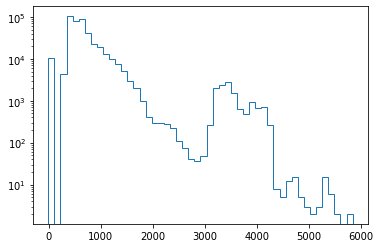

In [13]:
plt.hist(y[:,1]-y[:,0], bins=50, histtype='step');
plt.yscale('log')

While in previous applications, I cared about what was going on with the noise, now I'm going to cut off a lot of the noise so that I can only look at things that would really fuck up the data stream

In [14]:
X, y = X[(y[:,1]-y[:,0])>2000], y[(y[:,1]-y[:,0])>2000]

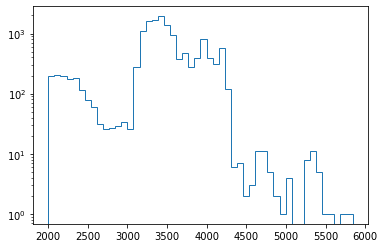

In [15]:
plt.hist(y[:,1]-y[:,0], bins=50, histtype='step');
plt.yscale('log')

Here's what the data looks like now

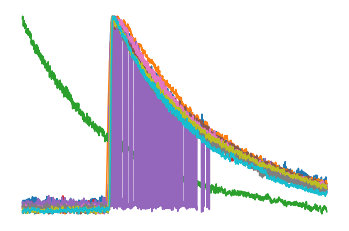

In [16]:
plt.plot(X[:10].T);
plt.axis('off');

# K means clustering
I only want to use enough clusters to be able to sort out data that doesn't look even close to a pulse.

In [17]:
kmean = KMeans(n_clusters=3, n_init=25, n_jobs=3)

In [18]:
kmean.fit(X);

In [19]:
clusterIDs = kmean.labels_

In [20]:
clusterE = [np.array([y[j,1]-y[j,0] for j in range(len(X)) if clusterIDs[j]==i]) for i in range(kmean.cluster_centers_.shape[0])]

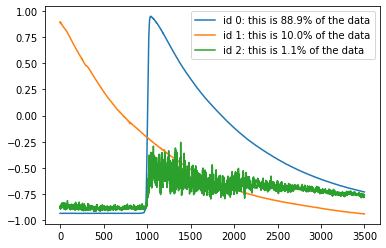

In [21]:
#fig = figure(figsize=(25,10))
for i in range(kmean.cluster_centers_.shape[0]):
    plot(kmean.cluster_centers_[i], label='id '+str(i)+': this is '+str(np.around(100*len(clusterE[i])/len(X),1))+'% of the data')
legend();

Now that I can see what the data looks like, I will chop off only that portion that matches a rough pulse shape, because pileup will look more like a pulse than the other options

In [22]:
X = X[kmean.labels_==0]

In [23]:
y = y[kmean.labels_==0]

# outlier detection
## first up is support vector machines

I'm going to import the tools to do outlier detection then run through the reduced data set to find pileup

In [24]:
from sklearn.svm import OneClassSVM

In [25]:
svm = OneClassSVM(nu=.01, gamma='scale')

In [26]:
clf = svm.fit(X)

In [27]:
scores = clf.predict(X)

Found some!

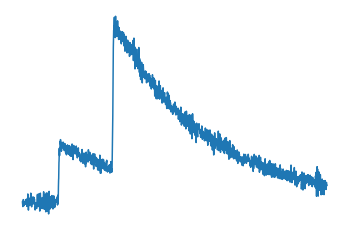

In [41]:
plt.plot(X[scores==-1][13]);
plt.axis('off');

I'll try to find similar pileup with nearest neighbors

In [44]:
import sklearn.neighbors

In [46]:
nbrs = sklearn.neighbors.BallTree(X)

In [73]:
dists, indices = nbrs.query(X[scores==-1][13:14], k=6)

In [74]:
indices = indices.flatten()

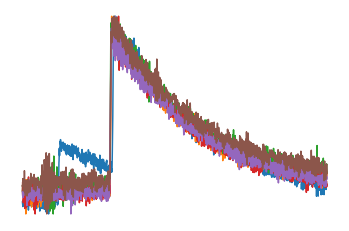

In [75]:
plt.plot(X[indices].T);
plt.axis('off');

It didn't find anything so I will go back to manually sorting through the data. I think it failed because the pileup occured unusually early in the signal

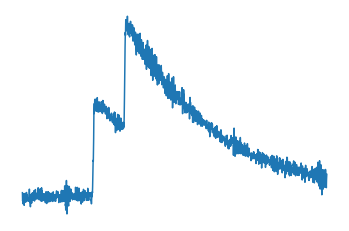

In [112]:
plt.plot(X[scores==-1][47]);
plt.axis('off');

maybe this one will have more neighbors that are pileup since it is more like the usual case

In [113]:
nbrs = sklearn.neighbors.BallTree(X)

In [122]:
dists, indices = nbrs.query(X[scores==-1][47:48], k=20)

In [123]:
indices = indices.flatten()

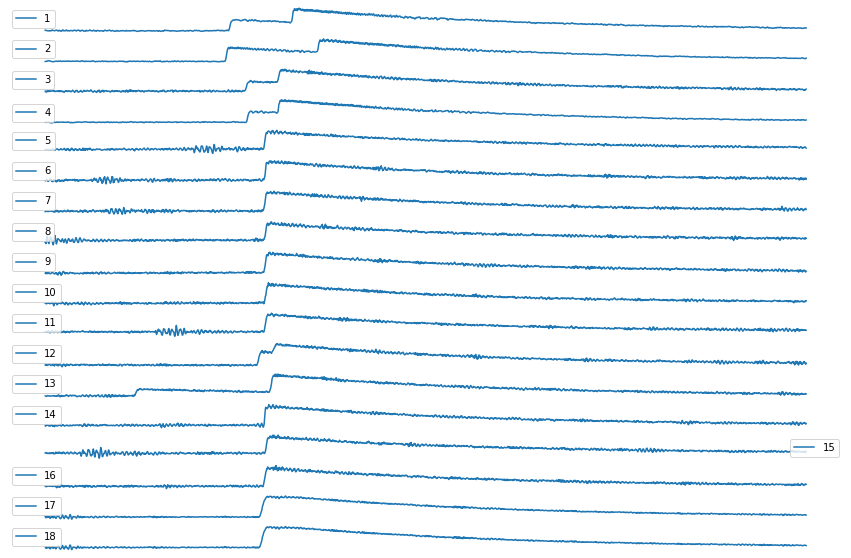

In [129]:
plt.subplots(18,1,figsize=(15,10))
for i in range(1,19):
    plt.subplot(18,1,i)
    plt.plot(X[indices[i]], label=str(i));
    plt.legend()
    plt.axis('off');

The only ones that aren't pileup are 5-11, 14-

In [135]:
first_pileup = next(i for i in range(len(X)) if (X[i]==X[scores==-1][13]).all())

In [156]:
pileup_ids = np.array(first_pileup)

In [157]:
pileup_ids = np.append(pileup_ids, indices[:5])
pileup_ids = np.append(pileup_ids, indices[12:14])

Now I have a good list of pileup ids!

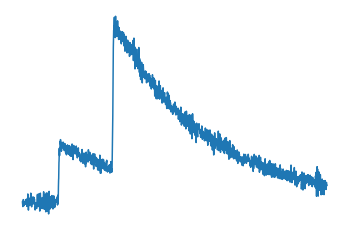

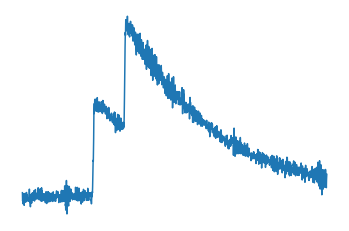

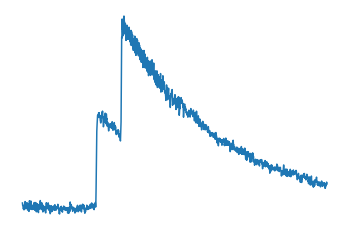

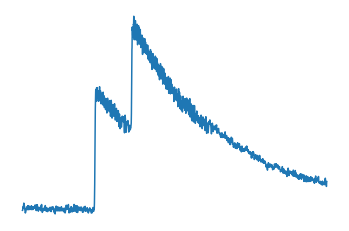

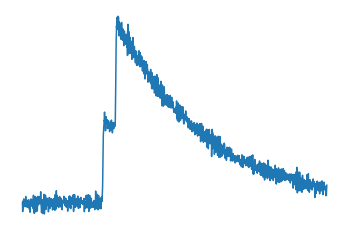

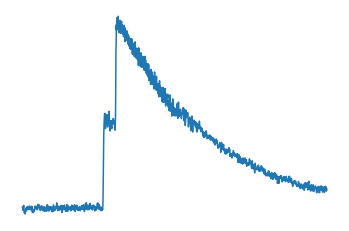

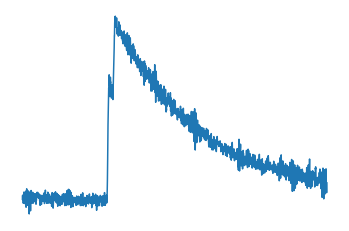

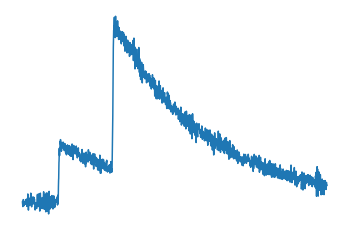

In [158]:
for x in X[pileup_ids]: plt.plot(x); plt.axis('off'); plt.show()

In [160]:
ls pileup/

pileup_X2.npy  pileup_X.npy


In [161]:
rm pileup/*

In [162]:
np.save('pileup.npy', X[pileup_ids])

Now I have some pileup identified and saved!

# Local Outlier Factor

Time to do the same thing with Local Outlier Factor

In [163]:
from sklearn.neighbors import LocalOutlierFactor

In [164]:
Lof = LocalOutlierFactor(n_neighbors=5, contamination=.01)

In [165]:
y_pred = Lof.fit_predict(X)

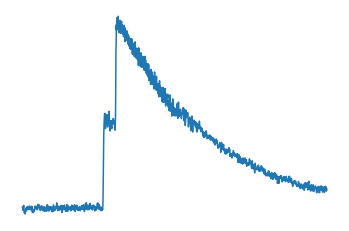

In [202]:
plt.plot(X[y_pred==-1][-22]);
plt.axis('off');

Wow that's really close in terms of time delay!

# Isolation Forest

Trying another approach - isolation forests. I don't expect this to do very well, but we'll have to wait and see

In [22]:
from sklearn.ensemble import IsolationForest

In [23]:
isf = IsolationForest(contamination=0.01, behaviour='new')

In [24]:
y_pred = isf.fit_predict(X)

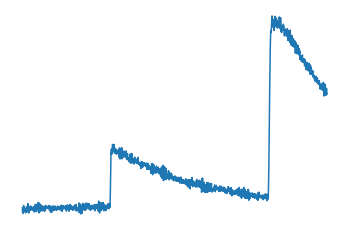

In [25]:
plt.plot(X[y_pred==-1][0]);
plt.axis('off');

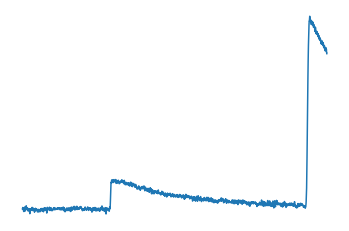

In [44]:
plt.plot(X[y_pred==-1][-2]);
plt.axis('off');

Wow there are very different from the other pileup events that I found! I'm glad I am using multiple methods

# Fast ICA

This is a signal processing technique to identify independent signals. I have used it on some signals that I know have pileup to see if it identifies the two independent signals. It does not, but I leave it in because I tried it.

In [234]:
from sklearn.decomposition import FastICA

In [247]:
# Comsklearn ICA
ica = FastICA(n_components=2)
S_ = ica.fit_transform(X[p_ids])  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

In [248]:
S_.shape

(8, 2)

In [250]:
A_.shape

(3500, 2)

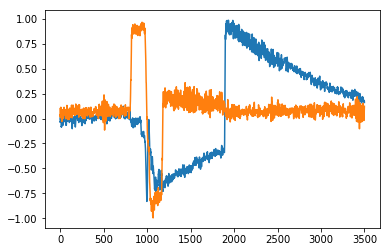

In [251]:
for x in A_.T:
    plt.plot(x)

In [238]:
A_.shape

(3500, 3)

# Conclusion
## I was able to find pileup in the data using several different methods - combining all methods gives the broadest range of results